# STAT5243 Project 3: Imbalanced image classification

#### Group 2:

## Step 0: Set up

In [282]:
# Note for Wendy: the notebook is primarily controlled by buttons
# Everytime you make a change in any script, you would need to save it and run the first two cells again to validify the change
# Or you can copy and paste a script function to a new cell and edit it here until it works well, and then paste it back to the 
# script and re-run the first two cells

In [1]:
RUN_TEST = False # whether if run evaluation on the test set

In [2]:
%run "../lib/functions.py" #general functions
%run "../lib/feature.py" #feature extraction
if RUN_TEST:
    %run "../lib/test.py"
else:
    %run "../lib/train.py"
    %run "../lib/validation.py"

In [3]:
import os
wd = os.getcwd()
output_dir = os.path.join(os.path.dirname(wd), "output\\")
output_dir

'C:\\Users\\PhoneGor\\Documents\\Coding\\Spring2021-Project3-group-2\\output\\'

Install libraries as needed: [tensorflow](https://www.tensorflow.org/install), imbalanced-learn

`!pip install imbalanced-learn`

In [4]:
#import tensorflow and check version
import tensorflow as tf
print(tf.__version__)

# import imlearn and check version number
import imblearn
print(imblearn.__version__)


2.4.1
0.8.0


Note: Google colab has tensorflow installed, but if you use Anaconda jupyter book,
you need to copy and paste the following command into the anaconda prompt
`conda install -c conda-forge tensorflow` or install tensorflow inside the jupyter notebook by the line 
`!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org --upgrade tensorflow`

Import other libraries and set up parameters as needed.

In [5]:
import glob
import cv2
import pandas as pd
import numpy as np
import random
import sys
import time
import scipy.io as sio
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')
#import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import sklearn.preprocessing
from sklearn.svm import SVC#, DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier 
from sklearn.ensemble import VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, roc_curve, plot_roc_curve, auc, pairwise_distances
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline, Pipeline


scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

from tensorflow.keras import datasets, layers, models

# Set a random seed for reproduction.
RANDOM_STATE = np.random.seed(2020)

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 100
IMG_SIZE = 192
SHUFFLE_SIZE = 1000
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

%matplotlib inline

Set up controls for the evaluation experiments.

In [6]:
SAVE_FEATURE = True
READ_IMG = True # read images from directory
READ_PTS = True # read fiducial points from directory
RUN_CV = True # run cross-validation on the training set
RUN_SEARCH = False # run grid search on the training set to tune hyperparameters
SAMPLE_REWEIGHT = True # run sample reweighting in model training
K = 5  # number of CV folds
FIT_MODEL = True

RUN_FEATURES_TRAIN = False # process features for training set
RUN_FEATURES_TEST = False # process features for test set

Next, we need to get the paths to where the datasets are located.

In [7]:
# Reproduction: change paths to where you store the datasets
if RUN_TEST:
    path = 'C:\\Users\\Chloe\\Downloads\\test_set_predict\\'
    #|--test_set_predict
    #   |--points
    #      |--XXXX.mat
    #   |--images
    #      |--XXXX.jpg
    #   |--label_prediction.csv
else:
    path = 'C:\\Users\\PhoneGor\\Documents\\Coding\\Spring2021-Project3-group-2\\data\\train_set\\'

Set file directories for images, fiducial points and feature sets.

In [8]:
filenames = glob.glob(path+ "images/*.jpg") #path_imgs = f"data//train_set//images//{index:04d}.jpg"
pt_filenames = glob.glob(path+ "points/*.mat") #path_points = f"data//train_set//points//{index:04d}.mat"
filenames.sort()
pt_filenames.sort()

## Step 1: Load data

In [9]:
# load images in order
# Reference： https://appdividend.com/2020/09/19/python-cv2-understand-image-types-and-color-channels/
if READ_IMG:
    start = time.time()
    images = [cv2.imread(img) for img in filenames]
    print("Time for reading images: ", round(time.time()-start,4), "s")

    # overview of the dataset
    print("Number of images: ", len(images))
    print("Size of each image: ",images[0].shape)

Time for reading images:  75.8336 s
Number of images:  3000
Size of each image:  (750, 1000, 3)


**Note: the dataset is imbalanced**

In [10]:
# read fiducial points from .mat files
# load_points(path) function in functions.py
if READ_PTS:
    start = time.time()
    points_list = [load_points(path) for path in pt_filenames]
    print("Time for reading points: ", round(time.time()-start,4), "s")
    data_points = np.asarray(points_list, dtype=np.float32)
    print(data_points.shape)

Time for reading points:  3.7147 s
(3000, 78, 2)


In [11]:
# load labels
if RUN_TEST:
    labels = pd.read_csv(path+"label_prediction.csv")
else:
    labels = pd.read_csv(path+"label.csv")
print(labels['label'].value_counts())
n_zeros = labels['label'].value_counts()[0]
n_ones = labels['label'].value_counts()[1]

0    2402
1     598
Name: label, dtype: int64


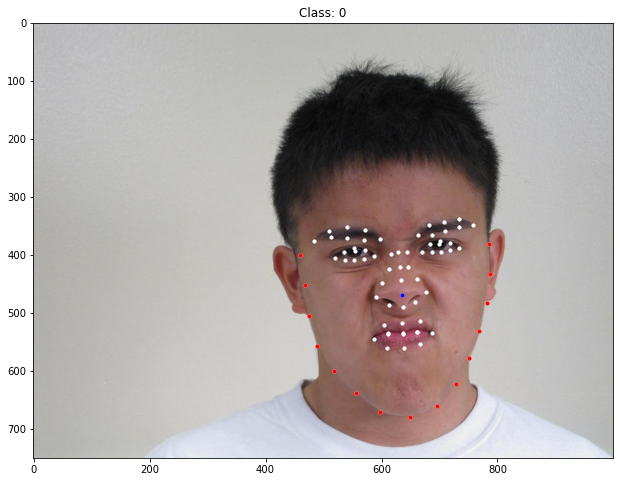

In [12]:
# show_original_image() function in functions.py
if RUN_TEST != True:
    show_orginal_image(images, data_points, labels, 1)

## Step 2: Data preprocessing

We used point 38 as the center of face and cropped a 450 \* 450 \* 3 RGB image to capture the face, and resized each image.

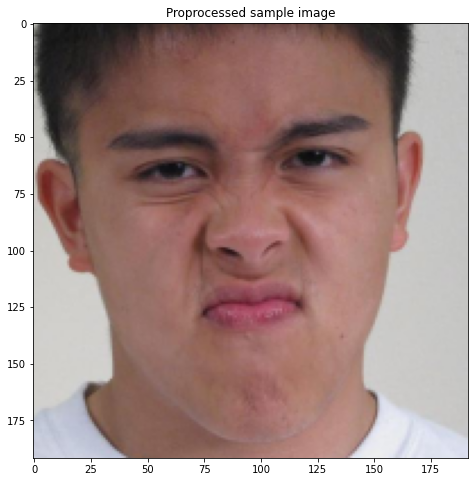

In [13]:
# propcess_image() function in functions.py
if RUN_TEST != True:
    plt.figure(figsize=(12, 8))
    plt.title("Proprocessed sample image")
    plt.imshow(cv2.cvtColor(preprocess_image(images, data_points, 1), cv2.COLOR_BGR2RGB))


## Step 3: Feature engineering

#### Feature set 1: pairwise spatial distances between points

In [14]:
RUN_TEST = True
SAVE_FEATURE =True
# Feature sets generating functions get_feature_1() and get_feature_2() in feature.py
if RUN_TEST:
    start = time.time()
    X_f1 = get_feature_1(data_points, np.array(labels['label']), rescale=True)
    print("Time for extracting feature set 1: ", round(time.time()-start,4), "s")
    if SAVE_FEATURE:
        np.savetxt(fname = output_dir + 'feature1.csv', X=X_f1, delimiter=',')
else:
    X_f1 = np.array(pd.read_csv(output_dir + "feature1.csv"))


Feature set 1 shape: (3000, 3003)
Time for extracting feature set 1:  0.6453 s


In [15]:
X_f1[0]

array([0.07058316, 0.02477416, 0.        , ..., 0.13286693, 0.29113835,
       0.12778303], dtype=float32)

#### Feature set 2:  distances between points and the center of all points

In [65]:
# Feature set 2: distances between points and the center of all points
if RUN_TEST:
    start = time.time()
    X_f2 = get_feature_2(data_points, np.array(labels['label']), rescale=True)
    print("Time for extracting feature set 2: ", round(time.time()-start,4), "s")
    if SAVE_FEATURE:
        np.savetxt(fname = output_dir + 'feature2.csv', X=X_f2, delimiter=',')
else: 
    X_f2 = np.array(pd.read_csv(output_dir + "feature2.csv"))


Feature set 2 shape: (3000, 78)
Time for extracting feature set 2:  0.02 s


#### Reduced feature set 1: reduced dimension with 100 attributes based on importance

In [18]:
# Reduce dimensionality of feature set 1 without losing feature interpretation
# select_k() in feature.py
RUN_TEST = True
SAVE_FEATURE=False
if RUN_TEST:
    start = time.time()
    X_f1_reduced = select_k(X_f1, y, k=100)
    print("Time for extracting reduced feature set 1: ", round(time.time()-start,4), "s")
    if SAVE_FEATURE:
        np.savetxt(fname = output_dir + 'feature1_reduced.csv', X=X_f1_reduced, delimiter=',')
else: 
    X_f1_reduced = np.array(pd.read_csv(output_dir + "feature1_reduced.csv"))

Shape of reduced feature set 1: (3000, 100)
Importance of critical fiducial points in 100 selected pairwise distances: 
Point: 20 , frequency: 16
Point: 6 , frequency: 15
Point: 29 , frequency: 14
Point: 30 , frequency: 13
Point: 21 , frequency: 12
Point: 26 , frequency: 8
Point: 35 , frequency: 8
Point: 7 , frequency: 8
Point: 12 , frequency: 7
Point: 49 , frequency: 7
Time for extracting reduced feature set 1:  0.2771 s


#### Response variable:

In [17]:
y = np.array(labels['label'])

#### Prepare a test set

In [19]:
if RUN_TEST == False:
    X_train, X_test, y_train, y_test = train_test_split(range(3000), labels['label'], test_size=0.2, random_state = RANDOM_STATE)
    ones = y_train[labels['label']==1]
    zeros = y_train[labels['label']==0]
    #filenames_1 = np.array(filenames)[ones.index]
    #filenames_0 = np.array(filenames)[zeros.index]
    print(y_train.value_counts())
    n_ones_train = y_train.value_counts()[0]
    n_zeros_train = y_train.value_counts()[1]
    n_ones_test = y_test.value_counts()[0]
    n_zeros_test = y_test.value_counts()[1]
    
    train_points = data_points[X_train]
    test_points = data_points[X_test]
    print(train_points.shape)
    y_train_arr = np.array(y_train)
    y_test_arr = np.array(y_test)
    print(y_train_arr.shape)
    
    X_tt_base = X_f1[X_test] #for baseline_gbm only
    X_tt = X_f1_reduced[X_test]
    y_tt = y_test

## Step 4: Data imbalance treatment with SMOTE

#### Strategy 1: Oversamping the minority with data augmentation

In [21]:
# ONLY RUN RESAMPLING FOR TRAIN DATA

# resample() function in train.py
# data_prepare() function in feature.py

if RUN_TEST == False:
    over1 = SMOTE(n_jobs = -1, random_state = RANDOM_STATE)
    over_X_f1, over_y = resample(over1, X_f1_reduced, y)
    if SAVE_FEATURE:
        feature1_o_balanced = np.append(over_X_f1, over_y.reshape(-1,1), axis=1)
        np.savetxt(fname = output_dir + 'feature1_o_balanced.csv', X=feature1_o_balanced, delimiter=',')
else:
    f1_o = np.array(pd.read_csv(output_dir + "feature1_o_balanced.csv"))
    over_X_f1, over_y = data_prepare(f1_o)

#### Stategy 2: A mix of oversampling the minority and undersampling the majority

In [22]:
if RUN_TEST == False:
    over2 = SMOTE(sampling_strategy=0.45, n_jobs = -1, random_state = RANDOM_STATE)
    under1 = RandomUnderSampler(sampling_strategy=1, random_state = RANDOM_STATE)
    resamp_X_f1, resamp_y = resample(over2, X_f1_reduced, y, model2=under1)
    if SAVE_FEATURE:
        feature1_ou_balanced = np.append(resamp_X_f1, resamp_y.reshape(-1,1), axis=1)
        np.savetxt(fname = output_dir + 'feature1_ou_balanced.csv', X=feature1_ou_balanced, delimiter=',')
else:
    f1_ou = np.array(pd.read_csv(output_dir + "feature1_ou_balanced.csv"))
    resamp_X_f1, resamp_y = data_prepare(f1_ou)

In [30]:
#### Note for Wendy: 
#### (X_f2, y) is same as the feature set you created
#### You can also use the three sets (X_f1_reduced, y), (over_X_f1, over_y), (resamp_X_f1, resamp_y) to tune parameters,
#### which seem to achieve higher auc

## Step 5: Model training and validation

#### Model 1: baseline GBM - gradient boosting machine classifier (with imbalanced features)
#### Model 2: Logistic Regression (with reduced imbalanced features)
#### Model 3: LDA (with reduced imbalanced features)
#### Model 4: Improved GBM (with oversampled features)
#### Model 5: SVM (with oversampled features)
#### Model 6: AdaBoost with base estimator BaggingClassifier (with oversampled features)
#### Model 7: BaggingClassifier with base estimator ExtraTreesClassifier (with oversampled features)
#### Model 8: SGDClassifier (with oversampled features)

Note: All models above have been tuned by grid search

In [23]:
if RUN_TEST:
    %run "../lib/test.py"
else:
    %run "../lib/train.py"
    %run "../lib/validation.py"

<Figure size 432x288 with 0 Axes>

In [33]:
## Will do:  

# Move grid search, validation procedures to validation.py

In [35]:
# Tuned models
# train() is the fitting method, in train.py

if FIT_MODEL:
    baseline_gbm_fitted, tm_base_gbm_fit = train(baseline_gbm, X_f1, y)
    LR_fitted, tm_LR_fit = train(LR, X_f1_reduced, y)
    LDA_fitted, tm_LDA_fit = train(LDA, X_f1_reduced, y)
    over1_gbm_fitted, tm_over_gbm_fit = train(over1_gbm, over_X_f1, over_y)
    svc_fitted, tm_svc_fit = train(svc, over_X_f1, over_y)
    ADA_fitted, tm_ADA_fit = train(ADA, over_X_f1, over_y)
    BAG_fitted, tm_BAG_fit = train(BAG, over_X_f1, over_y)
    SGD_fitted, tm_SGD_fit = train(SGD, over_X_f1, over_y)
    

NameError: name 'LDA' is not defined

In [236]:
# Note for Wendy: 
# Plz save param_grid for each model in validation.py, and save model instances in train.py
# To find best parameters by grid search and returns the best model:

# see function grid_search() in validation.py
#grid_search(X_f1_reduced, y, base_LR, param_grid_lr, cv=10, print_step = True, refit = 'roc_auc')

# Assign best model:
LR = grid_search(X_f1_reduced, y, base_LR, param_grid_lr, cv=10, print_step = True, refit = 'roc_auc')

Time for grid search: 4.7171 s
AUC 0.672 (+/-0.062) and accuracy 0.801 for {'C': 0.001, 'max_iter': 50, 'n_jobs': -1, 'solver': 'lbfgs'}
AUC 0.338 (+/-0.066) and accuracy 0.801 for {'C': 0.001, 'max_iter': 50, 'n_jobs': -1, 'solver': 'liblinear'}
AUC 0.672 (+/-0.062) and accuracy 0.801 for {'C': 0.001, 'max_iter': 100, 'n_jobs': -1, 'solver': 'lbfgs'}
AUC 0.338 (+/-0.066) and accuracy 0.801 for {'C': 0.001, 'max_iter': 100, 'n_jobs': -1, 'solver': 'liblinear'}
AUC 0.672 (+/-0.062) and accuracy 0.801 for {'C': 0.001, 'max_iter': 200, 'n_jobs': -1, 'solver': 'lbfgs'}
AUC 0.338 (+/-0.066) and accuracy 0.801 for {'C': 0.001, 'max_iter': 200, 'n_jobs': -1, 'solver': 'liblinear'}
AUC 0.674 (+/-0.061) and accuracy 0.801 for {'C': 0.01, 'max_iter': 50, 'n_jobs': -1, 'solver': 'lbfgs'}
AUC 0.354 (+/-0.071) and accuracy 0.801 for {'C': 0.01, 'max_iter': 50, 'n_jobs': -1, 'solver': 'liblinear'}
AUC 0.674 (+/-0.061) and accuracy 0.801 for {'C': 0.01, 'max_iter': 100, 'n_jobs': -1, 'solver': 'lbfgs

In [178]:
grid_search(X_f1_reduced, y, base_LR, param_grid_lr, cv=10, print_step = False, refit = 'roc_auc')

Time for grid search: 2.3245 s
Best 'roc_auc': 0.711
Accuracy: 0.801
Best parameters: {'C': 1.0, 'max_iter': 50, 'n_jobs': -1, 'solver': 'liblinear'}


LogisticRegression(max_iter=50, n_jobs=-1, solver='liblinear')

In [26]:
grid_search(X_f1_reduced, y, LDA, param_grid_LDA, cv=10, print_step = False, refit = 'roc_auc')

Time for grid search: 2.8475 s
Best 'roc_auc': 0.737
Accuracy: 0.804
Best parameters: {'shrinkage': 0.1, 'solver': 'lsqr'}


LinearDiscriminantAnalysis(n_components=1, shrinkage=0.1, solver='lsqr')

In [ ]:
# To run kfold CV on tuned model:

# function kfold_cv() in validation.py

RUN_CV = True
if RUN_CV:
    fpr_base_gbm, tpr_base_gbm, mean_auc_base_gbm, std_auc_base_gbm, mean_acc_base_gbm, std_acc_base_gbm = kfold_cv(
                baseline_gbm, X_f1, y, K = 5, lb="Baseline GBM on feature set 1", plot_roc=False)
    fpr_LR, tpr_LR, mean_auc_LR, std_auc_LR, mean_acc_LR, std_acc_LR = kfold_cv(
                LR, X_f1_reduced, y, K = 5, lb="LR on reduced feature set 1", plot_roc=False)
    fpr_lda, tpr_lda, mean_auc_lda, std_auc_lda, mean_acc_lda, std_acc_lda = kfold_cv(
                LDA, X_f1_reduced, y, K = 5, lb="LDA on reduced feature set 1", plot_roc=False)
    fpr_gbm, tpr_gbm, mean_auc_gbm, std_auc_gbm, mean_acc_gbm, std_acc_gbm = kfold_cv(
                over1_gbm, over_X_f1, over_y, K = 5, lb="Improved GBM on oversampled feature set 1", plot_roc=False)
    fpr_svm, tpr_svm, mean_auc_svm, std_auc_svm, mean_acc_svm, std_acc_svm = kfold_cv(
                svc, over_X_f1, over_y, K = 5, lb="SVM on oversampled feature set 1", plot_roc=False)
    fpr_BAG, tpr_BAG, mean_auc_bag, std_auc_bag, mean_acc_bag, std_acc_bag = kfold_cv(
                LR, X_f1_reduced, y, K = 5, lb="Bagging on oversampled feature set 1", plot_roc=False)
    fpr_SGD, tpr_SGD, mean_auc_sgd, std_auc_sgd, mean_acc_sgd, std_acc_sgd = kfold_cv(
                svc, over_X_f1, over_y, K = 5, lb="SGD on oversampled feature set 1", plot_roc=False)
    fpr_BAG, tpr_BAG, mean_auc_bag, std_auc_bag, mean_acc_bag, std_acc_bag = kfold_cv(
                BAG, over_X_f1, over_y, K = 5, lb="Bagging on oversampled feature set 1", plot_roc=False)
    fpr_SGD, tpr_SGD, mean_auc_sgd, std_auc_sgd, mean_acc_sgd, std_acc_sgd = kfold_cv(
                SGD, over_X_f1, over_y, K = 5, lb="SGD on oversampled feature set 1", plot_roc=False)
    fpr_ada, tpr_ada, mean_auc_ada, std_auc_ada, mean_acc_ada, std_acc_ada = kfold_cv(
                ADA, over_X_f1, over_y, K = 5, lb="AdaBoosting on oversampled feature set 1", plot_roc=True)

Model: Baseline GBM on feature set 1
Time for 5 fold CV: 767.4285 s
Mean accuracy = 0.832
Mean AUC = 0.807
Model: LR on reduced feature set 1
Time for 5 fold CV: 0.7469 s
Mean accuracy = 0.801
Mean AUC = 0.351
Model: LDA on reduced feature set 1
Time for 5 fold CV: 0.7435 s
Mean accuracy = 0.802
Mean AUC = 0.733
Model: Improved GBM on oversampled feature set 1
Time for 5 fold CV: 718.5736 s
Mean accuracy = 0.889
Mean AUC = 0.954


Model: Bagging on oversampled feature set 1
Time for 5 fold CV: 445.1769 s
Mean accuracy = 0.893
Mean AUC = 0.963
Model: SGD on oversampled feature set 1
Time for 5 fold CV: 0.5224 s
Mean accuracy = 0.672
Mean AUC = 0.704
Model: AdaBoosting on oversampled feature set 1
Time for 5 fold CV: 1884.4709 s
Mean accuracy = 0.925
Mean AUC = 0.976


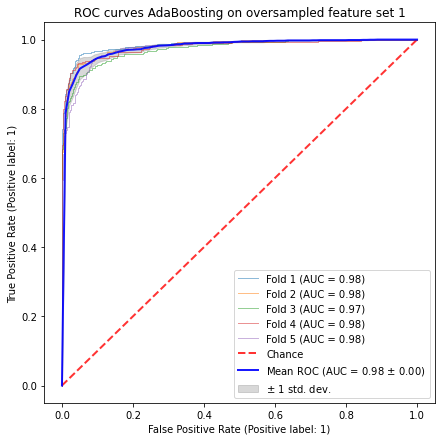

In [255]:
# graph for ada

In [272]:
# TO DO: not finished yet, this should be in test.py
SAVE_PRED = False
def predict_results(best_model, X:np.array, prob = False):
    """
    Takes fitted model and returns the prediction results and time for prediction.
    
    For training, the X array can be X_tt_base for baseline_gbm, 
    or X_tt for other models.
    """
    if prob == False:
        start = time.time()
        results = best_model.predict(X)
        tm = round(time.time()-start,4)
        if SAVE_PRED:
            np.savetxt(fname = output_dir + 'feature1_ou_balanced.csv', X=results, delimiter=',')
    else:
        start = time.time()
        results = best_model.predict_proba(X)
        tm = round(time.time()-start,4)
    return(results, tm)
        
    

In [148]:
# To test performance on the test set

print(488/600) # random guessing
Counter(y_tt)


0.8133333333333334


Counter({1: 112, 0: 488})

In [ ]:
# Time for testing
results = []
tm_test = []

models = [LR_fitted, LDA_fitted, over1_gbm_fitted, svc_fitted, ADA_fitted, BAG_fitted, SGD_fitted]

# The baseline_gbm model used a separate feature set with different dimensions, so we tested the baseline model separately
tm_test.append(predict_results(baseline_gbm_fitted, X_tt_base)[1])

for model in models:
    pred, tm = predict_results(model, X_tt)
    tm_test.append(tm)

print(tm_test)

In [224]:
ADA_fitted.score(X_tt, y_tt)

1.0

In [289]:
# Models are undecided yet, need to modify

#Model results overview
data = {'Classifier':['Baseline GBM', 'LogisticRegression', 'LDA', 'Improved GBM', 'AdaBoost (base estimator BaggingClassifier)','SVM', 
                      'Bagging (base estimator ExtraTreesClassifier)', 'SGD','RandomForestClassifier','KNN','VotingClassifier', 
                      'MLPClassifier','**Best model**: '], 
        'Training Time (s)':[tm_base_gbm_fit, tm_LR_fit, tm_LDA_fit, tm_over_gbm_fit, tm_ADA_fit, tm_svc_fit, 
                             tm_BAG_fit, tm_SGD_fit, 0, 0, 0, 
                             0, 0],
        'Testing Time (s)':[tm_test[0],tm_test[1],tm_test[2],tm_test[3],tm_test[4],tm_test[5],tm_test[6], tm_test[7],#tm_test
                            0, 0, 0, 
                            0, 0],
        'Claimed Accuracy (%)':[p(mean_acc_base_gbm, std_acc_base_gbm), p(mean_acc_LR, std_acc_LR), p(mean_acc_lda, std_acc_lda),
                                p(mean_acc_gbm, std_acc_gbm), p(mean_acc_ada, std_acc_ada), p(mean_acc_svm, std_acc_svm), 
                                p(mean_acc_bag, std_acc_bag), p(mean_acc_sgd, std_acc_sgd), 0, 0, 
                                0, 0, 0], 
        'Mean AUC':[p(mean_auc_base_gbm, std_auc_base_gbm), p(mean_auc_LR, std_auc_LR), p(mean_auc_lda, std_auc_lda),
                    p(mean_auc_gbm, std_auc_gbm), p(mean_auc_ada, std_auc_ada), p(mean_auc_svm, std_auc_svm), 
                    p(mean_auc_bag, std_auc_bag), p(mean_auc_sgd, std_auc_sgd), 0, 0, 
                    0, 0, 0],
} 

pd.DataFrame(data)

,Classifier,Training Time (s),Testing Time (s),Claimed Accuracy (%),Mean AUC
0,Baseline GBM,79.0925,0.0100,0.839 (+/-0.0131),0.7994 (+/-0.0154)
1,LogisticRegression,0.0240,0.0030,0.8007 (+/-0.0229),0.7106 (+/-0.0236)
2,LDA,0.3527,0.0010,0.803 (+/-0.0138),0.7362 (+/-0.0228)
3,Improved GBM,50.9020,0.0050,0.8 (+/-0.012),0.9274 (+/-0.0047)
4,AdaBoost (base estimator BaggingClassifier),512.5782,0.0430,0.9251 (+/-0.0083),0.9759 (+/-0.004)
5,SVM,79.2070,2.0480,0.8364 (+/-0.0098),0.901 (+/-0.0052)
6,Bagging (base estimator ExtraTreesClassifier),49.6303,33.2996,0.8934 (+/-0.0174),0.9631 (+/-0.0075)
7,SGD,0.0984,0.0030,0.6715 (+/-0.0289),0.704 (+/-0.0307)
8,RandomForestClassifier,0.0000,0.0000,0,0
9,KNN,0.0000,0.0000,0,0


In [ ]:
# Code below not modified yet

In [180]:
grid_search(over_X_f1, over_y, baseline_gbm, param_grid_gbm, cv=10)

Time for grid search: 349.7892 s
AUC 0.794 (+/-0.038) and accuracy 0.720 for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
AUC 0.796 (+/-0.038) and accuracy 0.721 for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}
AUC 0.794 (+/-0.030) and accuracy 0.720 for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
AUC 0.798 (+/-0.031) and accuracy 0.721 for {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 300}
AUC 0.854 (+/-0.043) and accuracy 0.771 for {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
AUC 0.874 (+/-0.041) and accuracy 0.792 for {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300}
AUC 0.851 (+/-0.037) and accuracy 0.774 for {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
AUC 0.868 (+/-0.047) and accuracy 0.787 for {'learning_rate': 0.

In [248]:
grid_search(over_X_f1, over_y, baseline_bag, param_grid_bag, cv=5)

Time for grid search: 1032.1196 s
AUC 0.971 (+/-0.023) and accuracy 0.900 for {'base_estimator': ExtraTreesClassifier(), 'max_features': 0.7, 'max_samples': 0.8, 'n_estimators': 100}
AUC 0.971 (+/-0.023) and accuracy 0.897 for {'base_estimator': ExtraTreesClassifier(), 'max_features': 0.7, 'max_samples': 0.8, 'n_estimators': 200}
AUC 0.972 (+/-0.023) and accuracy 0.899 for {'base_estimator': ExtraTreesClassifier(), 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 100}
AUC 0.972 (+/-0.023) and accuracy 0.900 for {'base_estimator': ExtraTreesClassifier(), 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 200}
Best 'roc_auc': 0.972
Accuracy: 0.900
Best parameters: {'base_estimator': ExtraTreesClassifier(), 'max_features': 0.9, 'max_samples': 0.8, 'n_estimators': 200}


BaggingClassifier(base_estimator=ExtraTreesClassifier(), max_features=0.9,
                  max_samples=0.8, n_estimators=200, n_jobs=-1)

In [247]:
grid_search(over_X_f1, over_y, baseline_ada, param_grid_ada, cv=5)

Time for grid search: 661.7773 s
AUC 0.980 (+/-0.016) and accuracy 0.930 for {'base_estimator': BaggingClassifier(n_jobs=-1), 'learning_rate': 1, 'n_estimators': 100}
AUC 0.984 (+/-0.014) and accuracy 0.936 for {'base_estimator': BaggingClassifier(n_jobs=-1), 'learning_rate': 1, 'n_estimators': 200}
AUC 0.983 (+/-0.020) and accuracy 0.928 for {'base_estimator': ExtraTreesClassifier(), 'learning_rate': 1, 'n_estimators': 100}
AUC 0.983 (+/-0.018) and accuracy 0.928 for {'base_estimator': ExtraTreesClassifier(), 'learning_rate': 1, 'n_estimators': 200}
Best 'roc_auc': 0.984
Accuracy: 0.936
Best parameters: {'base_estimator': BaggingClassifier(n_jobs=-1), 'learning_rate': 1, 'n_estimators': 200}


AdaBoostClassifier(base_estimator=BaggingClassifier(n_jobs=-1), learning_rate=1,
                   n_estimators=200)

In [250]:
#sample_weight = 10* np.abs(np.random.randn(3000))
#sample_weight[:10] *= 10
CLASS_WEIGHT = {1:1, 0:4}

param_grid_sgd = {
    'loss': ['hinge','log','modified_huber','perceptron'],
    'penalty': ['l2','l1','elasticnet'],
    'alpha': [1e-4, 1e-5]
}
from sklearn.linear_model import SGDClassifier
base_sgd= SGDClassifier(#class_weight = class_weight, 
                                 n_jobs=-1, 
                                 random_state=RANDOM_STATE)

SGD = grid_search(over_X_f1, over_y, base_sgd, param_grid_sgd, cv=5)

Time for grid search: 2.2345 s
AUC 0.765 (+/-0.024) and accuracy 0.618 for {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l2'}
AUC 0.767 (+/-0.022) and accuracy 0.682 for {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l1'}
AUC 0.768 (+/-0.024) and accuracy 0.679 for {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'elasticnet'}
AUC 0.768 (+/-0.022) and accuracy 0.669 for {'alpha': 0.0001, 'loss': 'perceptron', 'penalty': 'l2'}
AUC 0.763 (+/-0.026) and accuracy 0.616 for {'alpha': 0.0001, 'loss': 'perceptron', 'penalty': 'l1'}
AUC 0.769 (+/-0.023) and accuracy 0.593 for {'alpha': 0.0001, 'loss': 'perceptron', 'penalty': 'elasticnet'}
AUC 0.776 (+/-0.024) and accuracy 0.619 for {'alpha': 1e-05, 'loss': 'modified_huber', 'penalty': 'l2'}
AUC 0.769 (+/-0.024) and accuracy 0.617 for {'alpha': 1e-05, 'loss': 'modified_huber', 'penalty': 'l1'}
AUC 0.775 (+/-0.020) and accuracy 0.629 for {'alpha': 1e-05, 'loss': 'modified_huber', 'penalty': 'elasticnet'}
AUC 0.771 (+/-0

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

In [ ]:
RUN_CV = False
if RUN_CV == False:
    f0_train = np.array(feature0.loc[X_train, feature0.columns != 'label'])
    f0_test = np.array(feature0.loc[X_test, feature0.columns != 'label'])
    
    start = time.time()
    baseline_gbm.fit(f0_train,y_train)
    print("Time fit: ", round(time.time()-start,4), "s")
    predictors=list(f0_train)
    #feature_imp = pd.Series(baseline_gbm.feature_importances_, predictors).sort_values(ascending=False).head(10)
    #feature_imp.plot(kind='bar', title='Importance of Features')
    #plt.ylabel('Feature Importance Score')
    print('Accuracy of the GBM on test set: {:.3f}'.format(baseline_gbm.score(f0_test, y_test)))
    start = time.time()
    y_pred = baseline_gbm.predict(f0_test)
    print("Time predict: ", round(time.time()-start,4), "s")
    print(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(np.array(y_test), np.array(y_pred), pos_label=1)
    sklearn.metrics.auc(fpr, tpr)

In [ ]:
# TN FP
# FN TP
#sklearn.metrics.confusion_matrix(y_test, y_pred)

#### Model : Simply CNN (on images)

##### Imbalanced data treatment

1) Resampling: Downsampling the majority and upsampling the minority
2) Put class weights in penalty
3) Data augmentation of the minority

In [ ]:
cnn_1 = tf.keras.Sequential([
    #layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    #layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.Rescaling(1./255.),
    #layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Conv2D(16, (3, 3), activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')#, 
                 #bias_initializer=tf.keras.initializers.Constant(initial_bias))
])

cnn_1.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=METRICS)


start = time.time()
history = cnn_1.fit(train_data, validation_data=val_data, 
                   steps_per_epoch=np.ceil(2.0*n_ones/BATCH_SIZE),
                   epochs=20)
                   #class_weight=class_weight)
print("Time fit: ", round(time.time()-start,4), "s")

cnn_1.summary()

In [ ]:
def plot_cnn_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    pred_e = [1-a for a in acc]
    val_pred_e = [1-a for a in val_acc]
    
    prec = history.history['precision']
    val_prec = history.history['val_precision']
    
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    #def plot_metrics(metrics_list):
    epochs_range = range(NUM_EPOCHS)
    
    plt.figure(figsize=(15, 15))
    
    plt.subplot(2, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.subplot(2, 3, 3)
    plt.plot(epochs_range, pred_e, label='Training Prediction Errors')
    plt.plot(epochs_range, val_pred_e, label='Validation Prediction Errors')
    plt.xlabel('Epoch')
    plt.ylabel('Prediction Error')
    plt.legend(loc='best')
    plt.title('Training and Validation Prediction Errors')
    
    plt.subplot(2, 3, 4)
    plt.plot(epochs_range, prec, label='Training Precision')
    plt.plot(epochs_range, val_prec, label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.title('Training and Validation Precision')
    
    plt.subplot(2, 3, 5)
    plt.plot(epochs_range, recall, label='Training Recall')
    plt.plot(epochs_range, val_recall, label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.title('Training and Validation Recall')
    
    plt.subplot(2, 3, 6)
    plt.plot(epochs_range, auc, label='Training AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend(loc='best')
    plt.title('Training and Validation AUC')
    
    plt.show()

#### Model : Pretrained CNN (on images)

In [ ]:
# pretrained model
def MobileNetV2_model(metrics=METRICS, output_bias=None, adam_lr=5e-3):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    MobileNetV2 = tf.keras.applications.MobileNetV2(include_top=False,
                                                   weights="imagenet",
                                                   input_shape=(IMG_SIZE, IMG_SIZE, 3))
    MobileNetV2.trainable = False 
    data_augmentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        #layers.experimental.preprocessing.RandomZoom(0.2)
    ])
    preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    dropout = tf.keras.layers.Dropout(0.2)
    
    model = tf.keras.Sequential([
        data_augmentation,
        preprocess_input,
        MobileNetV2,
        global_average_layer,
        prediction_layer
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=adam_lr),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                  metrics=metrics)

    return model


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)



In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                                   weights="imagenet",
                                                   input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False 
data_augmentation = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")
        #layers.experimental.preprocessing.RandomZoom(0.2)
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
dropout = tf.keras.layers.Dropout(0.2)
    
model = tf.keras.Sequential([
        data_augmentation,
        preprocess_input,
        base_model,
        global_average_layer,
        prediction_layer
])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-2),
                  loss=tf.keras.losses.BinaryCrossentropy(),#from_logits=True), 
                  metrics=METRICS)
class_weight = classWeights(n_zeros,n_ones)
NUM_EPOCHS = 20
start = time.time()
history = model.fit(train_data, validation_data=val_data, 
                   #callbacks=[early_stopping],
                   epochs=NUM_EPOCHS,
                   class_weight = class_weight)
print("Time fit: ", round(time.time()-start,4), "s")

In [ ]:
# 1) Upsampling the minority
# Train data
one_ds = ds_generator(list(ones.index))
one_ds = one_ds.repeat()
zero_ds = ds_generator(list(zeros.index))
zero_ds = zero_ds.repeat()

# Resample:
resampled_ds = tf.data.experimental.sample_from_datasets([one_ds, zero_ds], weights=[0.5, 0.5])

resampled_train_ds = resampled_ds.shuffle(SHUFFLE_SIZE)
resampled_train_data = resampled_train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

#val_data = resampled_ds.cache().batch(BATCH_SIZE).prefetch(2)


# Test data
test_ds = ds_generator(X_test)
test_data = test_ds.cache().batch(BATCH_SIZE)

#initial_bias = np.log([n_ones/n_zeros])[0]

In [ ]:
mobileNetV2_base = MobileNetV2_model()

NUM_EPOCHS = 20
start = time.time()
history = mobileNetV2_base.fit(train_data, validation_data=test_data, 
                          #callbacks=[early_stopping],
                          steps_per_epoch=np.ceil(2.0*n_ones/BATCH_SIZE),
                          epochs=NUM_EPOCHS)
print("Time fit: ", round(time.time()-start,4), "s")

In [ ]:
# 2) Reweight
#weight_for_0 = (1 / n_zeros)*(n_zeros+n_ones)/2.0 
#weight_for_1 = (1 / n_ones)*(n_zeros+n_ones)/2.0
class_weight = classWeights(n_zeros_test,n_ones_test)

train_ds = ds_generator(X_train)
test_ds = ds_generator(X_test)
train_ds = train_ds.cache()
train_data = train_ds.shuffle(SHUFFLE_SIZE)
train_data = train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_data = train_ds.cache().batch(BATCH_SIZE)
test_data = test_ds.cache().batch(BATCH_SIZE)

NUM_EPOCHS = 20
start = time.time()
history = mobileNetV2_base.fit(train_data, validation_data=val_data, 
                          #callbacks=[early_stopping],
                          epochs=NUM_EPOCHS,
                          class_weight = class_weight)
print("Time fit: ", round(time.time()-start,4), "s")

In [ ]:
# Set initial biases for imbalenced dataset
initial_bias = np.log([n_ones/n_zeros])
#mobileNetV2 = MobileNetV2_model(output_bias = initial_bias)




In [ ]:
mobileNetV2_base = MobileNetV2_model()
NUM_EPOCHS = 20
X_train, X_test, y_train, y_test = train_test_split(range(3000), labels['label'], test_size=0.2, random_state = RANDOM_STATE)
# Train data
ones = y_train[labels['label']==1]
zeros = y_train[labels['label']==0]




train_ds = ds_generator(X_train)
train_ds = train_ds.cache()
train_data = train_ds.shuffle(SHUFFLE_SIZE)
train_data = train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
print(train_ds)
print(train_data)
# Test data
test_ds = ds_generator(X_test)
test_data = test_ds.cache().batch(BATCH_SIZE)

#for img in train_ds.take(3):
#print(train_ds)
tm_cnn_fit = []

start = time.time()
history = mobileNetV2_base.fit(train_data, validation_data=test_data, 
                          callbacks=[early_stopping],
                          epochs=NUM_EPOCHS,
                          class_weight = class_weight)#, batch_size=20)
tm_cnn_fit.append(time.time() - start)

In [ ]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

# important to see what you are doing
plot_learning_rate(lr_decay, NUM_EPOCHS)

In [ ]:
# List all weight tensors 
# model.get_weights()
# plot metrics


# make predictions

test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)





#### 5-fold cross validated CNN

In [ ]:
import time
from sklearn.model_selection import LeaveOneOut, KFold
kf = KFold(n_splits = 5, random_state = 0, shuffle = True) 

VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_AUC = []

TIME_FIT = []

fold_var = 1

def get_model_name(k):
    return 'model_'+str(k)+'.h5'
#loo = LeaveOneOut()
#loo.get_n_splits(X)

y = labels['label']
for train_index, test_index in kf.split(np.zeros(3000),y):

    train_ds = ds_generator(train_index)
    val_ds = ds_generator(test_index) 
    
    for img, label in train_ds.take(1):
          print(img.shape, label.shape)
    for img, label in val_ds.take(1):
          print(img.shape, label.shape)
    
    train_data = train_ds.cache()
    train_data = train_ds.shuffle(SHUFFLE_SIZE)
    train_data = train_data.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    test_data = val_ds.cache().batch(BATCH_SIZE)
    
    for img, label in train_data.take(1):
          print(img.shape, label.shape)
    for img, label in test_data.take(1):
          print(img.shape, label.shape)
    
    # CREATE NEW MODEL
    initial_bias = np.log([n_ones/n_zeros])
    mobileNetV2 = MobileNetV2_model(output_bias = initial_bias)
    
    # CREATE CALLBACKS
    checkpoint_path = os.path.join(output_dir, get_model_name(fold_var))
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                            monitor='val_auc', verbose=1, 
                            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    start = time.time()
    history = mobileNetV2.fit(train_data, validation_data=test_data, epochs=20)
    TIME_FIT.append(time.time() - start)
    #PLOT HISTORY
    #		:
    #		:
    
    # LOAD BEST MODEL to evaluate the performance of the model
    mobileNetV2.load_weights(output_dir+"model_"+str(fold_var)+".h5")
    
    results = mobileNetV2.evaluate(val_data)
    results = dict(zip(mobileNetV2.metrics_names,results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    VALIDATION_PRECISION.append(results['precision'])
    VALIDATION_RECALL.append(results['recall'])
    VALIDATION_AUC.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

# r environment

In [ ]:
!pip install rpy2

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%R 